In [1]:
import numpy as np
import math 
import bitarray
from math import *
from matplotlib import pyplot as plt

In [2]:
## shift : the amount on which the basis function is shifted by
## number : the number of the basis function start at 0
##number = t
T = 1 ##The lenght of the basis function
value = 1/math.sqrt(T) ## The height of the function considering it is a rect

f_s = 22050
T_s = 1/f_s
sigma = 0.05


#x the basis number
def basis(x,t):
    if x >T and x<=(1+T) : 
        return value
    
def r(t) :
    return sinc(t)

def basis_rect(t) :
    return 

In [3]:
def fourier_transform(x, start, end):
    nb_coef = end - start
    result = np.zeros(nb_coef)
    n = np.arange(x.shape[0])
    for f in np.arange(start, end):
        result[f - start] = np.abs(np.sum(x/f_s * np.exp(-2*1j*pi* f * (n/f_s))))
    
    return result

In [4]:
#pss_array = pss()
#plt.plot(fourier_transform(pss_array, -4000, 4000))

In [5]:
B = 0.8
T = 2

def root_raised_cos(t):
    return 4*B / (pi*sqrt(T)) * (cos((1+B)*pi*t/T) + (1-B)*pi/(4*B)*np.sinc((1-B)*t/T))/ (1 - (4*B*t/T)**2)

In [6]:
def root_raised_cos_v2(t, T):
    if t == np.abs(T/(4*B)) : 
        return B/(pi*sqrt(2*T)) * ((pi + 2)*np.sin(pi/(4*B)) + (pi - 2)*cos(pi/(4*B)))
    else :
        return 4*B / (pi*sqrt(T)) * (cos((1+B)*pi*t/T) + (1-B)*pi/(4*B)*np.sinc((1-B)*t/T))/ (1 - (4*B*t/T)**2)

In [7]:
root_raised = np.vectorize(root_raised_cos_v2)

In [8]:
#Working : 50*T_s and -500, 501

In [21]:
nb_samples_root_raised = 200
n_T = 10 # number of samples to get to T in the root raised cosinus n_t = T/Ts
n = nb_samples_root_raised//2
t_s = np.arange(-n, n)/f_s
root_raised_12_Ts = root_raised(t_s, n_T*T_s)
root_raised_12_Ts_rescaled = root_raised_12_Ts/(np.max(root_raised_12_Ts)*3/2)

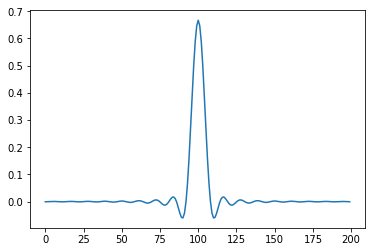

In [22]:
plt.plot(root_raised_12_Ts_rescaled)

In [23]:
basis_2 = root_raised_12_Ts_rescaled

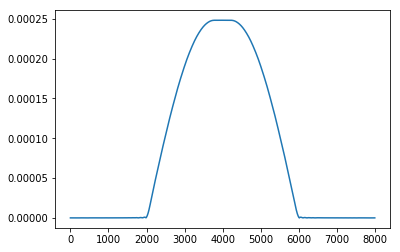

In [24]:
plt.plot(fourier_transform(basis_2, -4000, 4000))

In [25]:
def text_to_bit(text):
    ba = bitarray.bitarray()
    ba.frombytes(text.encode('utf-8'))
    ba = np.fromiter(map(lambda x : 1 if x else 0, ba.tolist()), dtype = int)
    return ba

In [26]:
def bit_to_text(bit):
    ba = bitarray.bitarray(bit.tolist())
    r = ba.tobytes()
    return  str(r,'utf8')

In [27]:
#right now convert (0,1) array to (-1 , 1) array
def b_to_c(array):
    c_s = (array -1/2)*2
    return c_s

In [28]:
##### Design a transmitter that reads a text file and returns real-valued samples of an
#information-bearing signal s[n].
#arg text_file : an array of sended values
const_size = 2
def transmitter(text_file, basis_size):
    size = text_file.shape[0]
    result = np.zeros(size*basis_size)
    for i in range(size):
        result[basis_size*i:basis_size*(i+1)] = text_file[i]*basis_2
    return result

In [31]:
def transmitter_2(text_file):
    text_size = text_file.shape[0]
    result = np.zeros(nb_samples_root_raised + n_T * (text_size -1))

    for i in range(text_size) :
        #print(text_file[i]*root_raised_12_Ts_rescaled)
        result[n_T*i : nb_samples_root_raised + n_T*i] += text_file[i]*root_raised_12_Ts_rescaled
    return result
    

In [32]:
def create_random(size):
    random_text =  np.sign(np.random.rand(size) -0.5)
    result = np.zeros(nb_samples_root_raised *size)
    for i in range(size) : 
        result[nb_samples_root_raised*i:nb_samples_root_raised*(i+1)] = root_raised_12_Ts_rescaled * random_text[i]
    return result        

In [33]:
def create_random(size):
    random_text =  np.sign(np.random.rand(size) -0.5)
    
    return random_text

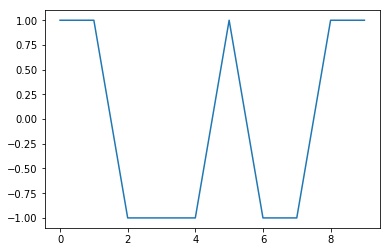

In [34]:
plt.plot(create_random(10))

In [35]:
def low_pass(arr, f_0):
    T = 2*f_0
    t = np.arange(-100,100)/f_s
    sinc = T *np.sinc(T*t)
    
    return np.convolve(arr/f_s, sinc, mode = 'same')

In [36]:
def shift(arr, f_0):
    indices = np.arange(arr.shape[0])
    return (arr * np.sqrt(2) * np.exp(1j * 2 * pi * f_0 * indices/f_s))/np.sqrt(2)

In [37]:
##test
arr= np.array([1,1,1,0,0,0])
f = 3000
np.real(shift(shift(arr, f),-f))

array([1., 1., 1., 0., 0., 0.])

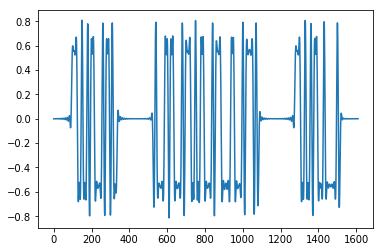

In [38]:
string_text = "Carapaz"
random_size = int(50*len(string_text)/100)
start_random = create_random(8*random_size)
end_random = create_random(8*random_size)
constellation = b_to_c(text_to_bit(string_text))
size_sent = len(constellation)

#constellation = np.concatenate( (start_random, constellation, end_random) , axis = 0)
a_transmitted = transmitter_2(constellation)


#a_transmitted = np.concatenate( (start_random,a_transmitted, end_random), axis = 0)
start_transmitted = transmitter_2(start_random)
end_transmitted = transmitter_2(end_random)
message_transmitted = np.concatenate((start_transmitted, a_transmitted, end_transmitted))
plt.plot(message_transmitted)
convolution_start = np.correlate(message_transmitted,start_transmitted , mode = 'valid')
convolution_end = np.correlate(message_transmitted,end_transmitted , mode = 'valid')
max_before_channel = np.max(convolution_start)

f_1= 3000 # first value to shift
f_2 = 7000 # second value to shift 
message_transmitted = (shift(message_transmitted,f_1) + shift(message_transmitted, f_2))
message_transmitted = np.real(message_transmitted)


In [39]:
start = np.argmax(convolution_start)+len(start_transmitted)
end = np.argmax(convolution_end)
#print(end-start)
print(a_transmitted.shape)
print(message_transmitted[start:end].shape)
#plt.plot(convolution_start[100:250][60:80])

(750,)
(750,)


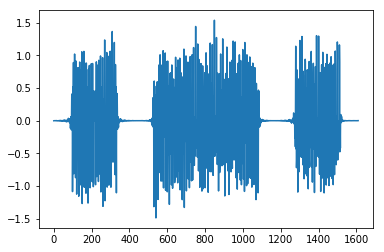

In [40]:
plt.plot(message_transmitted)

71.83319922364478


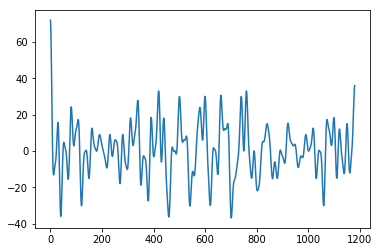

In [41]:
plt.plot(convolution_start)
print(max_before_channel)

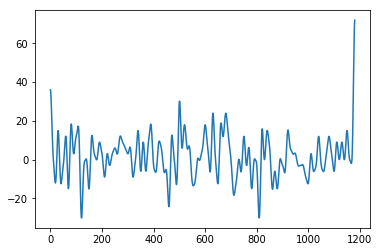

In [42]:
plt.plot(convolution_end)

In [43]:
a = np.argmax(convolution_start) + len(start_transmitted)

b = np.argmax(convolution_end)
print(b-a)

750


In [44]:
np.savetxt('input.txt', message_transmitted)

In [45]:
!python3 client.py --input_file='input.txt' --output_file='output.txt' --srv_hostname=iscsrv72.epfl.ch --srv_port=80

In [46]:
output = np.loadtxt('output.txt')
#output = message_transmitted

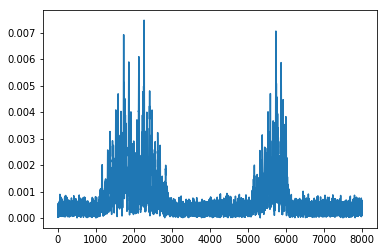

In [47]:
plt.plot(fourier_transform(output,1000,9000))

In [48]:
norm_1 = np.linalg.norm(fourier_transform(output, 1000, 3000))
norm_2 = np.linalg.norm(fourier_transform(output, 3000, 5000))
norm_3 = np.linalg.norm(fourier_transform(output, 5000, 7000))
norm_4 = np.linalg.norm(fourier_transform(output, 7000, 9000))
fallen_index = np.argmin(np.array([norm_1, norm_2, norm_3, norm_4]))

#######
#fallen_index = 2
######

print("Part {} has fallen".format(fallen_index +1 ))

Part 4 has fallen


In [49]:
if fallen_index < 2:
    output_low_passed = low_pass(shift(output, -f_2), 2000)
else :
    output_low_passed = low_pass(shift(output, -f_1), 2000)

In [50]:
output_low_passed = output_low_passed*2

/Users/pldelacour/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


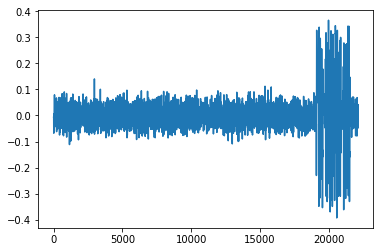

In [51]:
plt.plot(output_low_passed)

In [52]:
convolution_start = np.correlate(output_low_passed,start_transmitted, mode='valid' )
convolution_end = np.correlate(output_low_passed,end_transmitted , mode = 'valid')

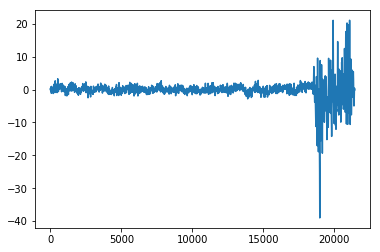

In [53]:
plt.plot(convolution_start)

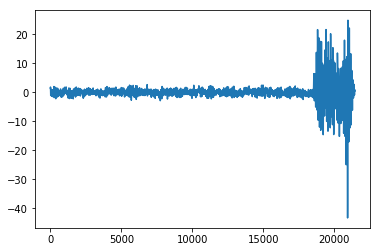

In [54]:
plt.plot(convolution_end)

In [55]:
#start = np.argmax(convolution_start - norm_start*convolved_norm_output) + len(transformed_start)//2
#end = np.argmax(convolution_end - norm_end*convolved_norm_output) - len(transformed_start)//2
start = np.argmax(np.abs(convolution_start))+len(start_transmitted)
end =  np.argmax(np.abs(convolution_end))
print(start, end)

19650 20951


In [56]:
print(len(start_transmitted))

660


Var_finale = a**2 * Var_debut + Var_bruit
=> a_factor = sqrt((Var_finale - Var_bruit)/Var_debut)
1) 0.34 2) 0.69

In [57]:
print(np.shape(a_transmitted),np.shape(output_low_passed[start:end]))

(1300,) (1301,)


In [58]:
def decode(array) : 
    size = len(basis_2)
    result = np.zeros(len(constellation))
    for i in range(len(constellation))  :
        result[i] = np.sum(basis_2*array[size*i: size*(i+1)])
    return (np.sign(result)+1)/2

In [59]:
def decode_2(array) :
    #print(array.shape)
    size_sent = int((len(array)-nb_samples_root_raised)/n_T + 1)
    result = np.zeros(size_sent)
    for i in range(size_sent):
        #result[i] = np.sum(basis_2 * array[n_T*i : 200+n_T*i])
        result[i] = np.sum(root_raised_12_Ts_rescaled * array[n_T*i : 200+n_T*i])
    return (np.sign(result)+1)/2  

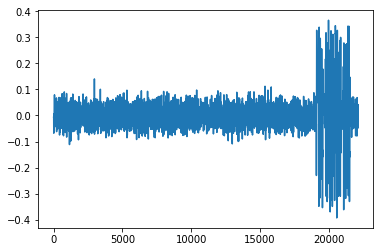

In [60]:
plt.plot(output_low_passed)

In [61]:
max_after_channel = np.max(convolution_start)
#print(max_after_channel)
#print(max_before_channel)
output_low_passed_rescaled = max_before_channel / max_after_channel * output_low_passed
#print(max_before_channel / max_after_channel)
array_2_low_passed = np.real(output_low_passed_rescaled[start:end])


In [62]:
d = decode_2(array_2_low_passed)
print(message_transmitted)
print(d)

result = bit_to_text(d)
print(result)
#print(result == string_text)

[ 0.00437059  0.00052362 -0.0015302  ...  0.00184638  0.00216364
 -0.00291366]
[1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 1.]


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb8 in position 0: invalid start byte

In [63]:
a = transmitter_2(b_to_c(np.array([1,1,1,0,0,0])))
#a = transmitter_2(b_to_c(text_to_bit("Constantin leceli")))
b = np.real(shift(a,3000) )
c = np.real(low_pass(shift(a,-3000), 2000))
#c = np.real(c)

#print(c)


print((decode_2(c)))

#print(root_raised_12_Ts_rescaled.shape)

[0. 1. 1. 0. 0. 1.]


In [67]:
a = transmitter_2(b_to_c(np.array([1,1,1,0,0,0])))
f = 3000000*T_s
b = np.real(shift(a,f) )

c = np.real(low_pass(shift(a,-f), 2000))
print(a-c)


[-8.52842089e-04 -1.19068472e-03 -1.57168140e-03 -1.93412977e-03
 -2.22477353e-03 -2.40698069e-03 -2.46462734e-03 -2.40139360e-03
 -2.23629557e-03 -1.99708157e-03 -1.71341928e-03 -1.41155340e-03
 -1.11143351e-03 -8.26432981e-04 -5.64977935e-04 -3.32917672e-04
 -1.35424078e-04  2.24098226e-05  1.36444889e-04  2.05323651e-04
  2.41754431e-03  2.36248738e-03  2.11006938e-03  1.68366453e-03
  1.11651962e-03  4.46021028e-04 -2.91280374e-04 -1.06232853e-03
 -1.83702347e-03 -2.58461865e-03 -3.26826261e-03 -3.83970768e-03
 -4.23650184e-03 -4.38362637e-03 -4.20058803e-03 -3.61363798e-03
 -2.57139784e-03 -1.06108172e-03  8.78002540e-04  3.14676844e-03
  7.77196705e-03  1.01257129e-02  1.20236124e-02  1.32241165e-02
  1.35156087e-02  1.27409346e-02  1.08176639e-02  7.75202924e-03
  3.64548719e-03 -1.30622803e-03 -6.82104613e-03 -1.25446982e-02
 -1.80702601e-02 -2.29624613e-02 -2.67862076e-02 -2.91386237e-02
 -2.96834701e-02 -2.81860734e-02 -2.45460903e-02 -1.88247389e-02
 -1.34481131e-02 -4.42293

In [65]:
##### qam
def qam(array):
    pad_val = int(T//T_s)
    int_size = pad_val + f_s
    
    loop_size = len(array)//2
    
    result = np.zeros(loop_size*int_size)
    
    for i in range(loop_size) : 
        r1 = array[2*i]*basis()
        r1 =  np.pad(r1, (0,pad_val) ,'constant', constant_values = (0))
        #need to pad to add 0 at the begining
        
        r2  = array[2*i+1]*basis()
        r2 =  np.pad(r2, (pad_val,0) ,'constant', constant_values = (0))
        r = r1+r2
        result[i*int_size : (i+1)*int_size ] = r
        
    return result

In [312]:
a = [1,-1,1]
qam(a)

TypeError: basis() missing 2 required positional arguments: 'x' and 't'